<a href="https://colab.research.google.com/github/Cyfraice/QuantumAI/blob/main/qcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9266 - auc: 0.9430 - loss: 0.2923 - precision: 0.9642 - recall: 0.8776 - val_accuracy: 0.9715 - val_auc: 0.9912 - val_loss: 0.0876 - val_precision: 0.9933 - val_recall: 0.9488
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9737 - auc: 0.9899 - loss: 0.0833 - precision: 0.9916 - recall: 0.9560 - val_accuracy: 0.9712 - val_auc: 0.9908 - val_loss: 0.0918 - val_precision: 0.9950 - val_recall: 0.9464
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9753 - auc: 0.9905 - loss: 0.0821 - precision: 0.9916 - recall: 0.9586 - val_accuracy: 0.9702 - val_auc: 0.9904 - val_loss: 0.0920 - val_precision: 0.9947 - val_recall: 0.9447
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9752 - auc: 0.9906 - loss: 0.0818 - precision: 0.9920 - recall: 0.9583 - val_accuracy: 0.9748 - val_auc: 0.9913 - val_loss: 0.0845 - val_precision: 0.9916 - val_recall: 0.9572
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 

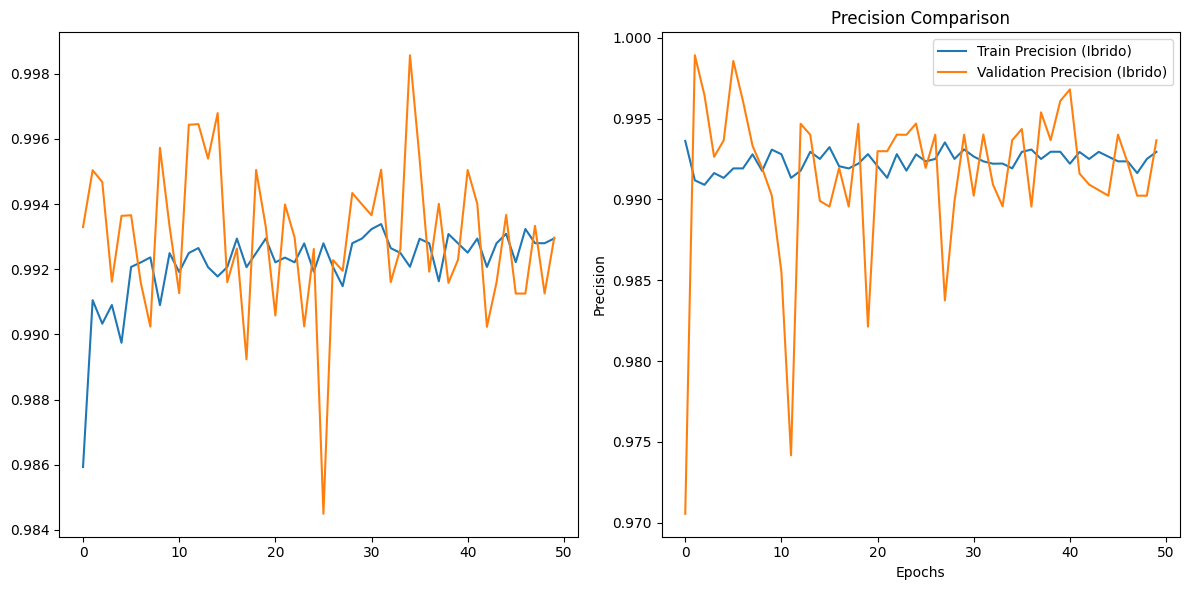

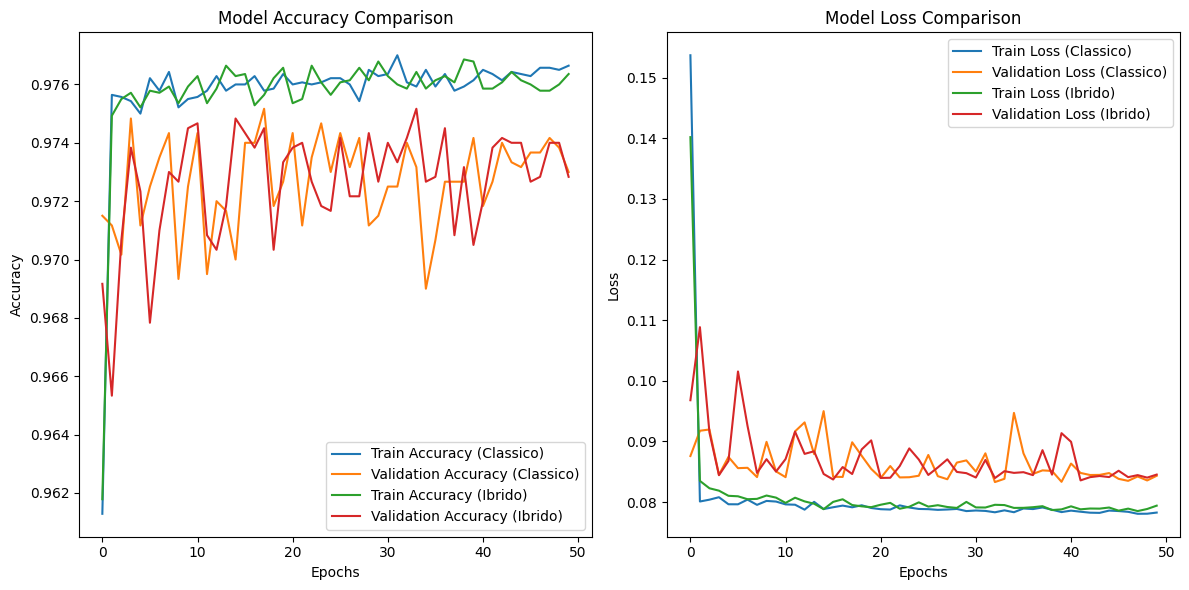

In [12]:
# !pip install pennylane
import pennylane as qml
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Configurazione del dispositivo PennyLane (simulatore di qubit)
dev = qml.device("default.qubit", wires=4)


# Generare i dati delle particelle
def generate_data(num_samples=10000):
    X = []
    y = []

    for _ in range(num_samples):
        # Dati per flusso ordinato
        ordinato = np.random.normal(loc=0.0, scale=0.1, size=(2,))
        X.append(ordinato)
        y.append(0)  # Etichetta 0 per ordinato

        # Dati per flusso caotico
        caotico = np.random.normal(loc=0.5, scale=1.0, size=(2,))
        X.append(caotico)
        y.append(1)  # Etichetta 1 per caotico

    return np.array(X), np.array(y)


# Creazione del circuito quantistico per ottenere le caratteristiche quantistiche
@qml.qnode(dev)
def quantum_circuit(inputs):
    for i in range(4):
        qml.Hadamard(wires=i)  # Operatore Hadamard sui qubit

    # Codifica degli input
    qml.RZ(inputs[0], wires=0)
    qml.RZ(inputs[1], wires=1)

    # Strati di rotazione
    qml.RX(inputs[0], wires=2)
    qml.RX(inputs[1], wires=3)

    # Misura in PauliZ e raccolta dei valori
    return [qml.expval(qml.PauliZ(i)) for i in range(4)] + \
           [qml.expval(qml.PauliX(i)) for i in range(4)] + \
           [qml.expval(qml.PauliY(i)) for i in range(4)] + \
           [qml.expval(qml.PauliY(i)) for i in range(4)]


def generate_quantum_features(X):
    features = []
    for x in X:
        features.append(quantum_circuit(x))
    return np.array(features)


# Generazione dataset
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Generazione caratteristiche quantistiche
X_train_quantum = generate_quantum_features(X_train)
X_test_quantum = generate_quantum_features(X_test)


X_train_reshaped = X_train.reshape(-1, 2, 1)
X_test_reshaped = X_test.reshape(-1, 2, 1)


# CNN classica
model_classic = models.Sequential([
    layers.InputLayer(input_shape=(2, 1)),  # Due feature per ogni campione
    layers.Conv1D(32, kernel_size=2, activation='relu', padding='same'),  # Layer convoluzionale
    layers.MaxPooling1D(pool_size=2, padding='same'),  # Max pooling
    layers.Conv1D(64, kernel_size=2, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2, padding='same'),
    layers.Flatten(),  # Flatten
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dense(1, activation='sigmoid')  # Output con attivazione sigmoide per la classificazione binaria
])

# Compilazione del modello classico
model_classic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', "precision", "recall", "auc"])

# Addestramento del modello classico
history_classic = model_classic.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test))


# Definizione del modello ibrido
model_quantum = models.Sequential([
    layers.InputLayer(input_shape=(16,)),  # 16 valori per le *feature* quantistiche
    layers.Reshape((4, 4, 1)),
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])



# Compilazione del modello ibrido
model_quantum.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', "precision", "recall", "auc"])


# Addestramento del modello ibrido
history_quantum = model_quantum.fit(X_train_quantum, y_train, epochs=50, batch_size=32, validation_data=(X_test_quantum, y_test))



# Valutazione dei modelli
# Valutazione del modello classico
test_loss_classic, test_acc_classic, test_precision_classic, test_recall_classic, test_auc_classic = model_classic.evaluate(X_test_reshaped, y_test)

# Valutazione del modello quantistico
test_loss_quantum, test_acc_quantum, test_precision_quantum, test_recall_quantum, test_auc_quantum = model_quantum.evaluate(X_test_quantum, y_test)

# Stampa dei risultati per il modello classico
print(f"Modello classico - Loss: {test_loss_classic}, Accuracy: {test_acc_classic}, Precision: {test_precision_classic}, Recall: {test_recall_classic}, AUC: {test_auc_classic}")

# Stampa dei risultati per il modello quantistico
print(f"Modello quantistico - Loss: {test_loss_quantum}, Accuracy: {test_acc_quantum}, Precision: {test_precision_quantum}, Recall: {test_recall_quantum}, AUC: {test_auc_quantum}")




print(f"Test accuracy (classico): {test_acc_classic * 100:.2f}%")
print(f"Test accuracy (ibrido): {test_acc_quantum * 100:.2f}%")


#visualizzazione


# Calcolare le predizioni per i dati di test
y_pred_classic = model_classic.predict(X_test_reshaped)
y_pred_classic = (y_pred_classic > 0.5).astype(int)

y_pred_quantum = model_quantum.predict(X_test_quantum)
y_pred_quantum = (y_pred_quantum > 0.5).astype(int)

# Stampa del classification report per ogni modello
print("Classification Report - Classico")
print(classification_report(y_test, y_pred_classic))

print("Classification Report - Ibrido")
print(classification_report(y_test, y_pred_quantum))



# Precisione
plt.figure(figsize=(12, 6))

# Precisione per il modello classico
plt.subplot(1, 2, 1)
plt.plot(history_classic.history['precision'], label='Train Precision (Classico)')
plt.plot(history_classic.history['val_precision'], label='Validation Precision (Classico)')

# Precisione per il modello ibrido
plt.subplot(1, 2, 2)
plt.plot(history_quantum.history['precision'], label='Train Precision (Ibrido)')
plt.plot(history_quantum.history['val_precision'], label='Validation Precision (Ibrido)')

plt.title('Precision Comparison')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()



# Grafico di confronto tra i due modelli
plt.figure(figsize=(12, 6))





#Matrice di confusione
cm_classic = confusion_matrix(y_test, y_pred_classic)

cm_quantum = confusion_matrix(y_test, y_pred_quantum)

plt.figure(figsize=(6, 6))
sns.heatmap(cm_classic, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["True Neg", "True Pos"])
plt.title("Matrice di Confusione - Modello Classico")
plt.xlabel("Predizione")
plt.ylabel("Valore Reale")
plt.show()

plt.figure(figsize=(6, 6))
sns.heatmap(cm_quantum, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["True Neg", "True Pos"])
plt.title("Matrice di Confusione - Modello Quantistico")
plt.xlabel("Predizione")
plt.ylabel("Valore Reale")
plt.show()





# Accuratezza
plt.subplot(1, 2, 1)
plt.plot(history_classic.history['accuracy'], label='Train Accuracy (Classico)')
plt.plot(history_classic.history['val_accuracy'], label='Validation Accuracy (Classico)')
plt.plot(history_quantum.history['accuracy'], label='Train Accuracy (Ibrido)')
plt.plot(history_quantum.history['val_accuracy'], label='Validation Accuracy (Ibrido)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Perdita
plt.subplot(1, 2, 2)
plt.plot(history_classic.history['loss'], label='Train Loss (Classico)')
plt.plot(history_classic.history['val_loss'], label='Validation Loss (Classico)')
plt.plot(history_quantum.history['loss'], label='Train Loss (Ibrido)')
plt.plot(history_quantum.history['val_loss'], label='Validation Loss (Ibrido)')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5320 - loss: 0.6933 - val_accuracy: 0.5200 - val_loss: 0.6926
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4907 - loss: 0.6934 - val_accuracy: 0.5200 - val_loss: 0.6922
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5083 - loss: 0.6929 - val_accuracy: 0.5200 - val_loss: 0.6918
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5063 - loss: 0.6931 - val_accuracy: 0.5200 - val_loss: 0.6916
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5394 - loss: 0.6896 - val_accuracy: 0.5200 - val_loss: 0.6912
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.5200 - val_loss: 0.6908
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5066 - loss: 0.6917 - val_accuracy: 0.5200 - val_loss: 0.6895
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5119 - loss: 0.6906 - val_accuracy: 0.5200 - val_loss

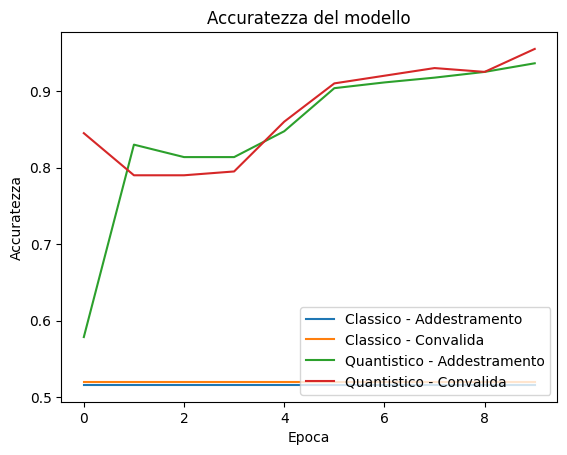

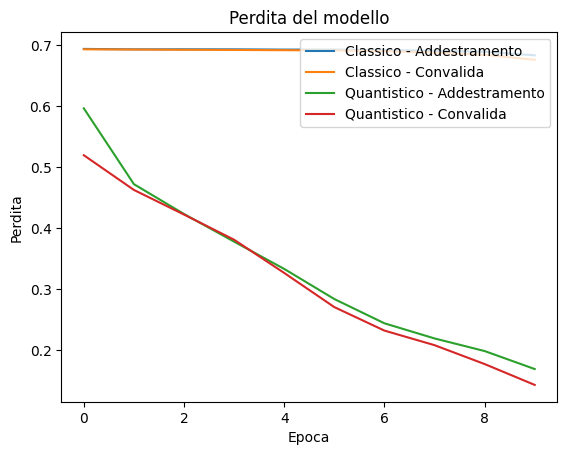

Accuratezza classica: 0.5199999809265137
Accuratezza quantistica: 0.9549999833106995


In [ ]:
#!pip install pennylane
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pennylane as qml
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Parametri della simulazione
Lx, Ly, Lz = 10.0, 10.0, 10.0  # Dimensioni del dominio
Nx, Ny, Nz = 32, 32, 32  # Risoluzione griglia
dx, dy, dz = Lx / Nx, Ly / Ny, Lz / Nz
nu = 0.01  # Viscosità cinematica
dt = 0.01  # Passo temporale
steps = 100  # Numero di passi temporali

# Funzione della simulazione
def simulate_flow(Nx, Ny, Nz, nu, dt, steps, turbulent=False):
    u = np.zeros((Nx, Ny, Nz))
    v = np.zeros((Nx, Ny, Nz))
    w = np.zeros((Nx, Ny, Nz))

    if turbulent:
        # Genera rumore che evolve nel tempo
        u = np.random.randn(Nx, Ny, Nz) * 0.1
        v = np.random.randn(Nx, Ny, Nz) * 0.1
        w = np.random.randn(Nx, Ny, Nz) * 0.1

        # Aggiungere il rumore temporale alla simulazione
        for step in range(steps):
            noise_u = np.random.randn(Nx, Ny, Nz) * 0.05  # Rumore casuale
            noise_v = np.random.randn(Nx, Ny, Nz) * 0.05
            noise_w = np.random.randn(Nx, Ny, Nz) * 0.05

            u += noise_u * dt
            v += noise_v * dt
            w += noise_w * dt
    else:
        u = np.ones((Nx, Ny, Nz)) * 0.1
        v = np.zeros((Nx, Ny, Nz))
        w = np.zeros((Nx, Ny, Nz))

    for _ in range(steps):
        grad_u = np.gradient(u, dx, axis=0), np.gradient(u, dy, axis=1), np.gradient(u, dz, axis=2)
        grad_v = np.gradient(v, dx, axis=0), np.gradient(v, dy, axis=1), np.gradient(v, dz, axis=2)
        grad_w = np.gradient(w, dx, axis=0), np.gradient(w, dy, axis=1), np.gradient(w, dz, axis=2)

        laplacian_u = np.gradient(grad_u[0], dx, axis=0) + np.gradient(grad_u[1], dy, axis=1) + np.gradient(grad_u[2], dz, axis=2)
        laplacian_v = np.gradient(grad_v[0], dx, axis=0) + np.gradient(grad_v[1], dy, axis=1) + np.gradient(grad_v[2], dz, axis=2)
        laplacian_w = np.gradient(grad_w[0], dx, axis=0) + np.gradient(grad_w[1], dy, axis=1) + np.gradient(grad_w[2], dz, axis=2)

        u += nu * laplacian_u * dt
        v += nu * laplacian_v * dt
        w += nu * laplacian_w * dt

    return u, v, w

# Genera il dataset
def generate_dataset(samples):
    data = []
    labels = []
    for _ in range(samples):
        # Variazione casuale dei parametri
        nu_varied = np.random.uniform(0.005, 0.05)  # Viscosità
        dt_varied = np.random.uniform(0.005, 0.05)  # Passo temporale
        steps_varied = np.random.randint(50, 200)  # Passi temporali
        is_turbulent = np.random.rand() > 0.5

        u, v, w = simulate_flow(Nx, Ny, Nz, nu_varied, dt_varied, steps_varied, turbulent=is_turbulent)

        # Estrazione feature: energia cinetica media
        energy = np.mean(u**2 + v**2 + w**2)
        data.append(energy)
        labels.append(1 if is_turbulent else 0)
    return np.array(data), np.array(labels)




dev = qml.device("default.qubit", wires=4)

# Circuito quantistico
@qml.qnode(dev)
def quantum_circuit(inputs):
    for i in range(4):
        qml.Hadamard(wires=i)

    qml.RZ(inputs[0], wires=0)
    qml.RZ(inputs[1], wires=1)

    qml.RX(inputs[0], wires=2)
    qml.RX(inputs[1], wires=3)

    return [qml.expval(qml.PauliZ(i)) for i in range(4)] + \
            [qml.expval(qml.PauliX(i)) for i in range(4)] + \
            [qml.expval(qml.PauliY(i)) for i in range(4)]

def generate_quantum_features(X):
    features = []
    for x in X:
        x = np.array([x, x])
        features.append(quantum_circuit(x))
    return np.array(features)




#DATI

#dataset
X, y = generate_dataset(1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Generazione delle caratteristiche quantistiche
X_train_quantum = generate_quantum_features(X_train)
X_test_quantum = generate_quantum_features(X_test)



scaler = StandardScaler()
X_train_quantum_scaled = scaler.fit_transform(X_train_quantum)
X_test_quantum_scaled = scaler.transform(X_test_quantum)


# CNN classica
def build_cnn(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(1,2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', "precision", "recall", "auc"])
    return model


X_train_reshaped = X_train.reshape(-1, 1, 1, 1)
X_test_reshaped = X_test.reshape(-1, 1, 1, 1)
X_train_quantum_reshaped = X_train_quantum_scaled.reshape(X_train_quantum_scaled.shape[0], 3, 4, 1)
X_test_quantum_reshaped = X_test_quantum_scaled.reshape(X_test_quantum_scaled.shape[0], 3, 4, 1)

input_shape_classic = (1, 1, 1)
input_shape_quantum = (3, 4, 1)


cnn_model_quantum = build_cnn(input_shape_quantum)

history_quantum = cnn_model_quantum.fit(X_train_quantum_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_quantum_reshaped, y_test))



X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

# Classic
cnn_model = Sequential([
    Dense(64, activation='relu', input_dim=1),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_classic = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



# accuratezza
plt.plot(history_classic.history['accuracy'], label='Classico - Addestramento')
plt.plot(history_classic.history['val_accuracy'], label='Classico - Convalida')
plt.plot(history_quantum.history['accuracy'], label='Quantistico - Addestramento')
plt.plot(history_quantum.history['val_accuracy'], label='Quantistico - Convalida')
plt.title('Accuratezza del modello')
plt.ylabel('Accuratezza')
plt.xlabel('Epoca')
plt.legend(loc='lower right')
plt.show()

# perdita
plt.plot(history_classic.history['loss'], label='Classico - Addestramento')
plt.plot(history_classic.history['val_loss'], label='Classico - Convalida')
plt.plot(history_quantum.history['loss'], label='Quantistico - Addestramento')
plt.plot(history_quantum.history['val_loss'], label='Quantistico - Convalida')
plt.title('Perdita del modello')
plt.ylabel('Perdita')
plt.xlabel('Epoca')
plt.legend(loc='upper right')
plt.show()


loss_classic, accuracy_classic = cnn_model.evaluate(X_test_reshaped, y_test, verbose=0)
loss_quantum, accuracy_quantum = cnn_model_quantum.evaluate(X_test_quantum_reshaped, y_test, verbose=0)

print(f"Accuratezza classica: {accuracy_classic}")
print(f"Accuratezza quantistica: {accuracy_quantum}")